In [324]:
# !pip install scikit-learn

In [1]:
import group_belief
from various_methods import all_methods
import math

import numpy as np
from matplotlib import pyplot as plt

In [2]:
class SimulatedSkill():
    def __init__(self, prob_slipping, prob_guessing, prob_learning, estimated_steps, is_unique, difficulty) -> None:
        self.difficulty = difficulty
        self.prob_slipping = prob_slipping
        self.prob_guessing = prob_guessing
        self.prob_learning = prob_learning
        self.estimated_steps = estimated_steps
        self.is_unique = is_unique

In [3]:
class SimulatedTask():
    def __init__(self, involved_skills, time) -> None:
        self.involved_skills = involved_skills
        self.time = time
    

In [4]:
class SimulatedStudy():
    def __init__(self, num_skills_per_difficulty, num_tasks) -> None:
        self.num_tasks = num_tasks
        self.num_skills_per_difficulty = num_skills_per_difficulty
        self.skills = {}
        self.easy_skills = {}
        self.medium_skills = {}
        self.hard_skills = {}
        self.tasks = {}

        for sid in range(num_skills_per_difficulty * 3):
            if sid < num_skills_per_difficulty:
                self.easy_skills[sid] = self.generate_skill(0)
                self.skills[sid] = self.easy_skills[sid]
            elif sid < num_skills_per_difficulty * 2:
                self.medium_skills[sid] = self.generate_skill(1)
                self.skills[sid] = self.medium_skills[sid]
            else:
                self.hard_skills[sid] = self.generate_skill(2)
                self.skills[sid] = self.hard_skills[sid]

        durations = np.linspace(250, 1000, num_tasks)

        for tid in range(num_tasks):
            time = round(durations[tid])
            
            if time <= 500:
                easy = np.random.choice(list(self.easy_skills.keys()), int(num_skills_per_difficulty / 2))
                medium = np.random.choice(list(self.medium_skills.keys()), int(num_skills_per_difficulty / 2))
                involved_skills = np.concatenate((easy, medium))
            elif time <= 750:
                easy = np.random.choice(list(self.easy_skills.keys()), int(num_skills_per_difficulty / 1.5))
                medium = np.random.choice(list(self.medium_skills.keys()), int(num_skills_per_difficulty / 2))
                easy_and_medium = np.concatenate((easy, medium))
                hard = np.random.choice(list(self.hard_skills.keys()), int(num_skills_per_difficulty / 3))
                involved_skills = np.concatenate((easy_and_medium, hard))
            else:
                easy = np.random.choice(list(self.easy_skills.keys()), int(num_skills_per_difficulty / 1.25))
                medium = np.random.choice(list(self.medium_skills.keys()), int(num_skills_per_difficulty / 1.5))
                easy_and_medium = np.concatenate((easy, medium))
                hard = np.random.choice(list(self.hard_skills.keys()), int(num_skills_per_difficulty / 2))
                involved_skills = np.concatenate((easy_and_medium, hard))
            
            self.tasks[tid] = SimulatedTask(involved_skills, time)

    def generate_skill(self, difficulty):
        prob_slipping = np.random.uniform(low = 0.1, high = 0.4)
        prob_guessing = np.random.uniform(low = 0.1, high = 0.4)
        prob_learning = np.random.uniform(low = 0.2, high = 0.8)
        if difficulty == 0:
            estimated_steps = np.random.randint(low = 20, high = 70)
        elif difficulty == 1:
            estimated_steps = np.random.randint(low = 70, high = 150)
        elif difficulty == 2:
            estimated_steps = np.random.randint(low = 150, high = 500)
        is_unique = np.random.choice([0, 1])
        return SimulatedSkill(prob_slipping, prob_guessing, prob_learning, estimated_steps, is_unique, difficulty)

In [5]:
def create_beliefs_methods(study, sids, uids, methods, methods_masteries, discussion_time, solve_time):
    beliefs_methods = {}
    for method in methods:
        beliefs = {}
        
        for sid in sids:
            p_L_0s = {}
            for uid in uids:
                p_L_0s[uid] = methods_masteries[method][uid][sid]

            skill = study.skills[sid]

            skill_belief = group_belief.GroupSkillBelief(sname=f'',
                                            sid=sid, 
                                            uids=uids, 
                                            p_L_0s=p_L_0s, 
                                            p_S=skill.prob_slipping, 
                                            p_G=skill.prob_guessing, 
                                            p_T=skill.prob_learning,
                                            n=15,
                                            discussion_time=discussion_time,
                                            solve_time=solve_time,
                                            usb=methods[method]["usb"],
                                            use_history=methods[method]["use_history"])
            beliefs[sid] = skill_belief

        beliefs_methods[method] = beliefs
    return beliefs_methods  

In [6]:
def simple_simulate_task(study, task, uids, current_real_masteries, methods, believed_mastery_methods, discussion_time, solve_time):
    real_masteries = {}
    for uid in uids:
        real_masteries[uid] = {}
        for sid in study.skills:
            real_masteries[uid][sid] = [current_real_masteries[uid][sid]]

    total_time = discussion_time + solve_time
    
    sids = task.involved_skills

    beliefs_methods = create_beliefs_methods(study, sids, uids, methods, believed_mastery_methods, discussion_time, solve_time)

    time = 0

    observations = {}
    last_actions = {}
    best_actions = {}
    attempted_learn = {}
    for sid in sids:
        observations[sid] = 0
        last_actions[sid] = {}
        best_actions[sid] = {}
        attempted_learn[sid] = {}
        for uid in uids:
            last_actions[sid][uid] = 0
            best_actions[sid][uid] = 0
            attempted_learn[sid][uid] = False

    while True:

        for sid in sids:
            simulated_skill = study.skills[sid]
            
            works_on_prob = {}

            worked_on = {}
            worked_on_group = 0

            for uid in uids:
                works_on_prob[uid] = (current_real_masteries[uid][sid] * (1 - simulated_skill.prob_slipping) + (1 - current_real_masteries[uid][sid]) * simulated_skill.prob_guessing) * (time / total_time)
                worked_on[uid] = np.random.choice([0, 1], p=[1 - works_on_prob[uid], works_on_prob[uid]])

                worked_on_group += worked_on[uid]

            if worked_on_group != 0:
                for uid in uids:
                    learn = np.random.choice([0, 1], p=[1 -(time / total_time), (time / total_time)])
                    if learn and not current_real_masteries[uid][sid] and not attempted_learn[sid][uid]:
                        attempted_learn[sid][uid] = True
                        current_real_masteries[uid][sid] = np.random.choice([0, 1], p=[1 - simulated_skill.prob_learning, simulated_skill.prob_learning]) 
                    last_actions[sid][uid] = worked_on[uid] / worked_on_group
                    best_actions[sid][uid] = max(best_actions[sid][uid], last_actions[sid][uid])
            observations[sid] = min(1, worked_on_group)

        for method in methods:
            beliefs = beliefs_methods[method]
            for sid in beliefs:
                c_ts = {}
                for uid in uids:
                    if observations[sid] == 1:
                        if beliefs[sid].use_history:
                            c_ts[uid] = best_actions[sid][uid]
                        else:
                            c_ts[uid] = last_actions[sid][uid]
                    else:
                        c_ts[uid] = 0
                
                beliefs[sid].step(observations[sid], c_ts)
            
        for uid in uids:
            for sid in study.skills:
                    real_masteries[uid][sid].append(current_real_masteries[uid][sid])

        if time >= total_time:
            break
        time += 1
        
    for method in methods:
        beliefs = beliefs_methods[method]
        for sid in beliefs:
            belief = beliefs[sid]
            for uid in belief.users:
                believed_mastery_methods[method][uid][sid] = belief.users[uid].H[-1]

    return beliefs_methods, real_masteries, believed_mastery_methods

In [7]:

def advanced_simulate_task(study, task, uids, current_real_masteries, methods, believed_mastery_methods, discussion_time, solve_time):
    real_masteries = {}
    for uid in uids:
        real_masteries[uid] = {}
        for sid in study.skills:
            real_masteries[uid][sid] = [current_real_masteries[uid][sid]]

    total_time = discussion_time + solve_time
    
    sids = task.involved_skills

    beliefs_methods = create_beliefs_methods(study, sids, uids, methods, believed_mastery_methods, discussion_time, solve_time)

    time = 0

    working_towards = {}
    working_against = {}

    do_required = {}
    undo_required = {}

    observations = {}
    last_actions = {}
    best_actions = {}
    for sid in sids:
        do_required[sid] = total_time
        undo_required[sid] = total_time
        observations[sid] = 0
        working_towards[sid] = {}
        working_against[sid] = {}
        last_actions[sid] = {}
        best_actions[sid] = {}
        for uid in uids:
            working_towards[sid][uid] = 0
            working_against[sid][uid] = 0
            last_actions[sid][uid] = 0
            best_actions[sid][uid] = 0

    who_picked = False

    while True:

        for sid in sids:
            simulated_skill = study.skills[sid]
            works_on_prob = {}
            not_works_on_prob = {}

            for uid in uids:
                works_on_prob[uid] = current_real_masteries[uid][sid] * (1 - simulated_skill.prob_slipping) + (1 - current_real_masteries[uid][sid]) * simulated_skill.prob_guessing
                not_works_on_prob[uid] = current_real_masteries[uid][sid] * simulated_skill.prob_slipping + (1 - current_real_masteries[uid][sid]) * (1 - simulated_skill.prob_guessing)

            if not who_picked:
                who_picked = True
                unique = simulated_skill.is_unique

                do_required[sid] = np.random.uniform(simulated_skill.estimated_steps - simulated_skill.estimated_steps / 2, simulated_skill.estimated_steps + simulated_skill.estimated_steps / 2, 1)[0]
                undo_required[sid] = np.random.uniform(simulated_skill.estimated_steps - simulated_skill.estimated_steps / 2, simulated_skill.estimated_steps + simulated_skill.estimated_steps / 2, 1)[0] * (1 + time / total_time)
                
                work_together_prob = 0.1
                total_works_on_prob = work_together_prob
                for uid in uids:
                    total_works_on_prob += works_on_prob[uid]  

                who = np.random.choice([-1, 0, 1], p=[work_together_prob / total_works_on_prob, works_on_prob[0] / total_works_on_prob, works_on_prob[1] / total_works_on_prob])
                
            for uid in uids:
                if uid == who or who == -1:
                    if unique:
                        if observations[sid] == 0:
                            working_towards[sid][uid] += np.random.choice([0, 1], p=[1 - works_on_prob[uid], works_on_prob[uid]])
                        else:
                            working_against[sid][uid] += np.random.choice([0, 1], p=[1 - not_works_on_prob[uid], not_works_on_prob[uid]])
                    else:
                        working_towards[sid][uid] += np.random.choice([0, 1], p=[1 - works_on_prob[uid], works_on_prob[uid]])
                        working_against[sid][uid] += np.random.choice([0, 1], p=[1 - not_works_on_prob[uid], not_works_on_prob[uid]])

            skill_done = 0
            skill_undone = 0
            for uid in uids:
                skill_done += working_towards[sid][uid]
                skill_undone += working_against[sid][uid]
                
            

            if skill_done > do_required[sid] and (not unique or not observations[sid]):
                observations[sid] = 1
                who_picked = False
                for uid in uids:
                    
                    old_contr = best_actions[sid][uid]
                    new_contr = working_towards[sid][uid] / skill_done
                    last_actions[sid][uid] = new_contr
                    if new_contr > old_contr:
                        best_actions[sid][uid] = new_contr
                    working_towards[sid][uid] = 0
                    working_against[sid][uid] = 0
                    probs_learn = simulated_skill.prob_learning
                    learns = np.random.choice([0, 1], p=[1 - probs_learn, probs_learn])
                    if current_real_masteries[uid][sid] == 0 and learns == 1:
                        current_real_masteries[uid][sid] = 1
            elif skill_undone > undo_required[sid] and (not unique or observations[sid]):
                who_picked = False
                observations[sid] = 0
                for uid in uids:
                    working_towards[sid][uid] = 0
                    working_against[sid][uid] = 0

        for method in methods:
            beliefs = beliefs_methods[method]
            for sid in beliefs:
                c_ts = {}
                for uid in uids:
                    if observations[sid] == 1:
                        if beliefs[sid].use_history:
                            c_ts[uid] = best_actions[sid][uid]
                        else:
                            c_ts[uid] = last_actions[sid][uid]
                    else:
                        c_ts[uid] = 0
                
                beliefs[sid].step(observations[sid], c_ts)
            
        for uid in uids:
            for sid in study.skills:
                    real_masteries[uid][sid].append(current_real_masteries[uid][sid])

        if time >= total_time:
            break
        time += 1
        
    for method in methods:
        beliefs = beliefs_methods[method]
        for sid in beliefs:
            belief = beliefs[sid]
            for uid in belief.users:
                believed_mastery_methods[method][uid][sid] = belief.users[uid].H[-1]

    return beliefs_methods, real_masteries, believed_mastery_methods


In [8]:
# Kullback Leibler Divergence
def kl(beliefs, real_masteries, time_steps):
    kls = np.empty([time_steps])
    for t in range(time_steps):
        sum = 0
        for sid in beliefs:
            skill_belief = beliefs[sid]
            for uid in skill_belief.users:
                current_mastery = real_masteries[uid][sid][t]
                current_belief = skill_belief.users[uid].H[t]
                sum += current_belief * math.log((current_belief + 0.001) / (current_mastery + 0.001)) + (1 - current_belief + 0.001) * math.log((1 - current_belief + 0.001) / (1 - current_mastery + 0.001))
        kls[t] = sum

    return kls

In [9]:
# Runs a full simulation, both simple and advanced
def whole_simulation(num_iter, num_tasks, simulation_type, plot_graphs=False, used_methods=all_methods, anova_time_steps=[49, 149, 249, 499, 749, 999]):

    all_method_correctness = {}
    anova_groups = {}


    durations = np.linspace(250, 1000, num_tasks)

    for tid in range(num_tasks):
        all_method_correctness[tid] = {}
        anova_groups[tid] = {}
        for anova_time_step in anova_time_steps:
            anova_groups[tid][anova_time_step] = {}
            for method in used_methods:
                anova_groups[tid][anova_time_step][method] = []
        for method in used_methods:
            all_method_correctness[tid][method] = np.zeros([num_iter, round(durations[tid])])

    for iteration in range(num_iter):
        study = SimulatedStudy(10, num_tasks)
        print(iteration)
        uids = [0, 1]

        current_real_masteries = {}
        believed_mastery_methods = {}

        for method in used_methods:
            believed_mastery_methods[method] = {}
            for uid in uids:
                current_real_masteries[uid] = {}
                believed_mastery_methods[method][uid] = {}
                for sid in study.skills:
                    believed_mastery_methods[method][uid][sid] = 0.5
                    current_real_masteries[uid][sid] = np.random.randint(2)

        for i in range(num_tasks):
            task = study.tasks[i]
            beliefs_methods, real_masteries, believed_mastery_methods = simulation_type(study, task, uids, current_real_masteries, used_methods, believed_mastery_methods, discussion_time=0, solve_time=task.time)

            for method in used_methods:
                all_method_correctness[i][method][iteration] = kl(beliefs_methods[method], real_masteries, task.time)

            current_real_masteries = {}
            for uid in uids:
                current_real_masteries[uid] = {}
                for sid in study.skills:
                    current_real_masteries[uid][sid] = real_masteries[uid][sid][-1]

            if plot_graphs and iteration == 0:
                group_belief.plot_all(beliefs_methods, real_masteries)
    
    iter_avgs = {}
    for tid in range(num_tasks):
        iter_avgs[tid] = {}
        for method in used_methods:
            iter_avgs[tid][method] = np.average(all_method_correctness[tid][method], axis=0).tolist()
            for anova_time_step in anova_time_steps:
                if all_method_correctness[tid][method].shape[1] > anova_time_step:
                    anova_groups[tid][anova_time_step][method] = list(all_method_correctness[tid][method][:, anova_time_step])
    
    return iter_avgs, anova_groups

def plot_correctness(simulation_data, num_tasks):
    print(simulation_data)
    for tid in range(num_tasks):

        plt.figure(figsize=(10, 6))

        for method in all_methods:
            durations = np.linspace(250, 1000, num_tasks)
            if tid in simulation_data:
                data = simulation_data[tid][method]
            elif str(tid) in simulation_data:
                data = simulation_data[str(tid)][method]
            plt.plot(np.arange(durations[tid]), np.array(data), linestyle='-', label={method})
        
        plt.xlabel('Time Step')
        plt.ylabel('Kullback-Leibler Divergence')
        plt.legend()
        plt.show()

In [333]:
iter_avgs, anova_groups = whole_simulation(1000, 4, advanced_simulate_task, plot_graphs=False)
import json
with open('anova_results/simulation_data_anova.json', 'w') as f:
    json.dump(iter_avgs, f)

with open('anova_results/simulation_data_anova_values.json', 'w') as f:
    json.dump(anova_groups, f)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

c:\Users\alexp\OneDrive\Documents\University and Work\University\FYP\final_year_project\myenv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


0
49
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.233     0.995    -1.156     0.689
 (0 - 2)      1.046     0.014     0.123     1.968
 (0 - 3)      0.378     0.920    -0.545     1.300
 (0 - 4)      1.412     0.000     0.489     2.334
 (0 - 5)      1.362     0.000     0.439     2.285
 (0 - 6)      1.420     0.000     0.498     2.343
 (0 - 7)      1.400     0.000     0.477     2.322
 (1 - 0)      0.233     0.995    -0.689     1.156
 (1 - 2)      1.279     0.001     0.356     2.202
 (1 - 3)      0.611     0.476    -0.312     1.534
 (1 - 4)      1.645     0.000     0.722     2.567
 (1 - 5)      1.595     0.000     0.673     2.518
 (1 - 6)      1.654     0.000     0.731     2.576
 (1 - 7)      1.633     0.000     0.710     2.555
 (2 - 0)     -1.046     0.014    -1.968    -0.123
 (2 - 1)     -1.279     0.001    -2.202    -0.356
 (2 - 3)     -0.668     0.355    -1.591     0.255
 (2 - 4)      0.366     0.9

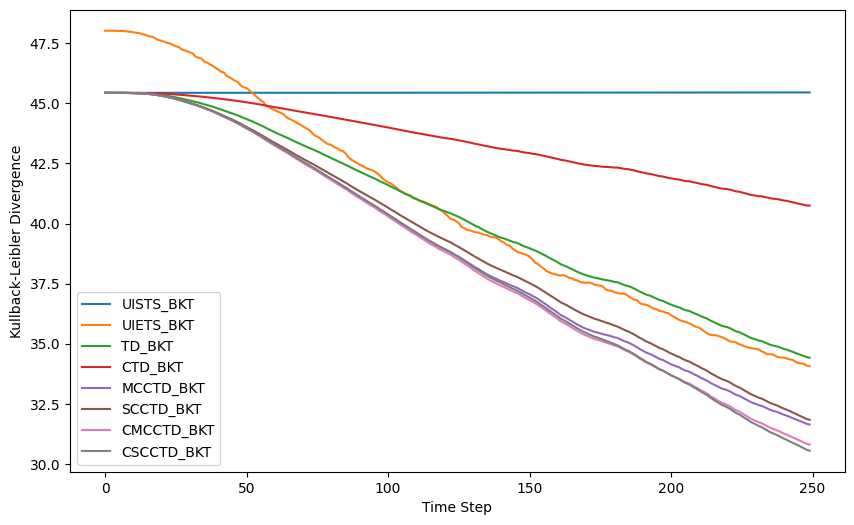

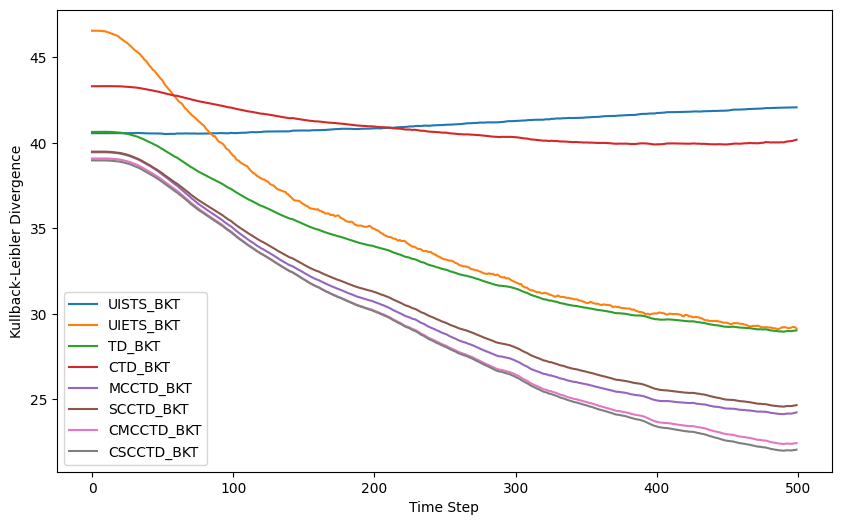

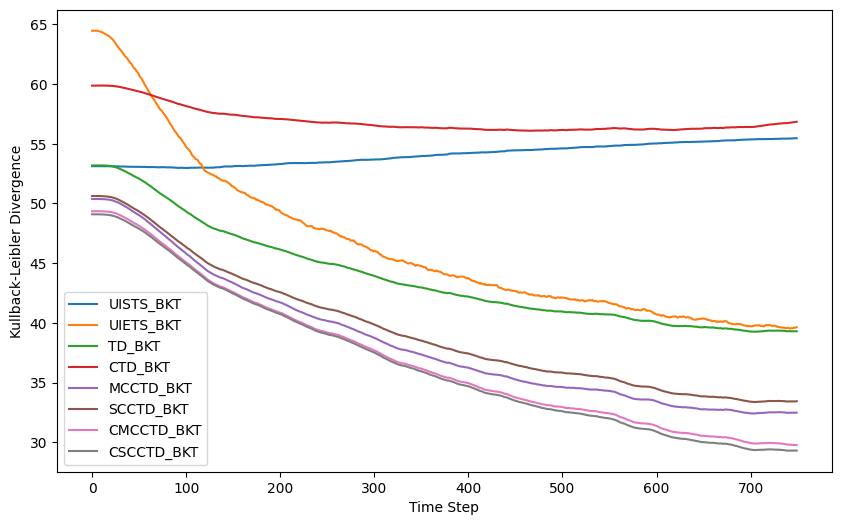

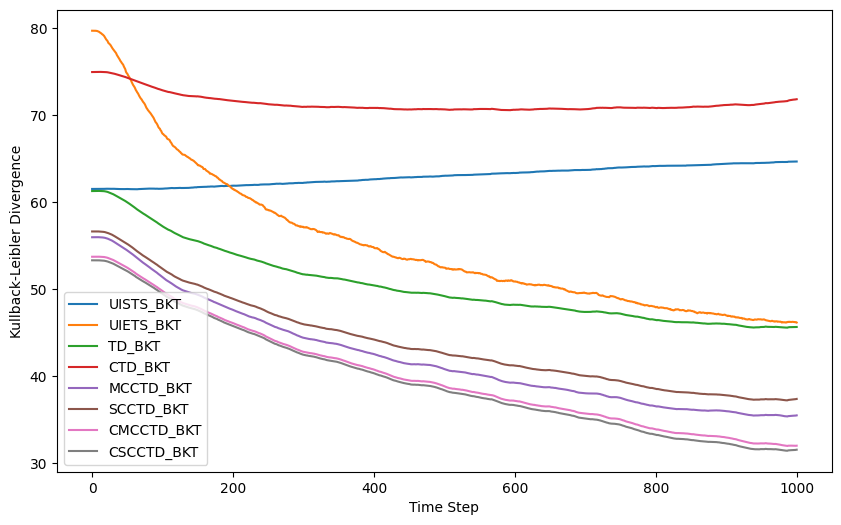

{0: {'UISTS_BKT': [45.43453148224746,
   45.43453148224746,
   45.43453148224746,
   45.43453148224746,
   45.43453148224746,
   45.43453148224746,
   45.43453148224746,
   45.43453148224746,
   45.43453839100224,
   45.434545299757026,
   45.4345522085118,
   45.43455911726658,
   45.434579843530926,
   45.43458675228571,
   45.434600569795265,
   45.43462820481438,
   45.4346558398335,
   45.43467656609784,
   45.43471801862652,
   45.434745653645635,
   45.43476637990997,
   45.4347940149291,
   45.43482164994822,
   45.434828558703,
   45.434849284967335,
   45.43488382874123,
   45.43494600753424,
   45.43498746006292,
   45.43502200383681,
   45.435063456365484,
   45.4350910913846,
   45.43509800013938,
   45.43516708768717,
   45.43519472270627,
   45.43524308398973,
   45.435325989047094,
   45.43536744157576,
   45.43540198534965,
   45.43545034663312,
   45.43549179916179,
   45.435553977954804,
   45.435609247993035,
   45.43563688301215,
   45.43572669682429,
   45.4357819

In [334]:
from scipy.stats import tukey_hsd

f = open('anova_results/simulation_data_anova_values.json') 

anova_groups = json.load(f)

for tid in anova_groups:
    task_groups = anova_groups[tid]
    for time_step in task_groups:
        method_groups = task_groups[time_step]
        if len(method_groups["UISTS_BKT"]) != 0:
            res = tukey_hsd(method_groups["UISTS_BKT"], method_groups["UIETS_BKT"], method_groups["TD_BKT"], method_groups["CTD_BKT"], method_groups["MCCTD_BKT"], method_groups["SCCTD_BKT"], method_groups["CMCCTD_BKT"], method_groups["CSCCTD_BKT"])
            print(tid)
            print(time_step)
            print(res)

f = open('anova_results/simulation_data_anova.json') 

data = json.load(f)

plot_correctness(data, 4)